## Import packages and functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d.axes3d import Axes3D

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
# sns.set_style("whitegrid")

from cycler import cycler
import itertools
import time
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

## Import Data

In [3]:
# Database file can be downloaded at: https://www.kaggle.com/hugomathien/soccer
# Connect to database
database = 'database.sqlite'
conn = sqlite3.connect(database)

#Fetch data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)
conn.close()

## Define functions needed for feature building

In [4]:
###### VECTORIZED CODE: 8.5 TIMES FASTER ###########
def find_previous(index, team, season, stage):
    """Determine previous match given season, stage, and team name
       Returns index and stage number of previous game played by team
       If no game is found it returns current index and stage"""
       
    tmp_stage = stage
    assigned = False
    # look for previous match, if needed go back all the way to first game
    while (tmp_stage >= 2) & (not assigned):
        previous = betdf[(betdf['season']==season) & (betdf['stage']==tmp_stage-1) & ((betdf['home_team_api_id']==team) | (betdf['away_team_api_id']==team))]
        if previous.shape[0] == 1:
            previous_stage = previous['stage'].item()
            previous_index = previous.index[0]
            assigned = True
        else:
            tmp_stage -= 1
    
    # Check if previous game was found, if not (went back to first game!) use current stage and index
    if not assigned:
        previous_stage = stage
        previous_index = index
    return previous_index, previous_stage      

    
def get_points(index, home, away, season, stage):
    """Given index, home and away teams, season, and stage, computes (and assigns to betdf) 
       average points up to previous game for both teams"""
    # Recover index number and stage of previous game
    previous_index_h, previous_stage_h = find_previous(index, home, season, stage)
    previous_index_a, previous_stage_a = find_previous(index, away, season, stage)

    # Assign avg_point for home team when a previous game was found
    if previous_stage_h != stage:
        # Identify field in previous game
        if betdf.loc[previous_index_h,'home_team_api_id'] == home:
            previous_field_h = 'home'
        else:
            previous_field_h = 'away'
        mydict = {'home':0, 'away':1}
        avg_points_h = ((stage-2)*betdf.loc[previous_index_h,'points_'+previous_field_h] + \
                      points_dict[betdf.loc[previous_index_h,'outcome']][mydict[previous_field_h]])/(stage-1)          
    # Assign points for home team when previous game was not found
    else:
        avg_points_h = 0.0
    # Actual assignment to betdf
    betdf.loc[index,'points_home'] = avg_points_h
    
    # Assign avg_point for away team when a previous game was found
    if previous_stage_a != stage:
        # Identify field in previous game
        if betdf.loc[previous_index_a,'home_team_api_id'] == away:
            previous_field_a = 'home'
        else:
            previous_field_a = 'away'
        mydict = {'home':0, 'away':1}
        avg_points_a = ((stage-2)*betdf.loc[previous_index_a,'points_'+previous_field_a] + \
                      points_dict[betdf.loc[previous_index_a,'outcome']][mydict[previous_field_a]])/(stage-1)  
    # Assign points for away team when previous game was not found
    else:
        avg_points_a = 0.0
    # Actual assignment to betdf
    betdf.loc[index,'points_away'] = avg_points_a
       


In [5]:
# Vectorization of streak_feature
# it assigns streak values directly to betdf, without returning them

def get_streak(index,n):
    """Adds average points feature up to previous games to dataframe"""
    
    stage=betdf.loc[index,'stage']
    # Computations for home team of 'current (index)' game
    tmp_stage = stage
    assigned = False
    while (tmp_stage-n>0) & (not assigned):
        subdf = betdf[(betdf['season']==betdf.loc[index,'season']) & (betdf['stage']==(tmp_stage-n)) & \
                ((betdf['home_team_api_id']==betdf.loc[index,'home_team_api_id']) | \
                 (betdf['away_team_api_id']==betdf.loc[index,'home_team_api_id']))]
        if subdf.shape[0] != 0:
            assigned = True
            if subdf.iloc[0]['home_team_api_id']==betdf.loc[index,'home_team_api_id']:
                betdf.loc[index,'streak_home'] = (betdf.loc[index,'points_home']*(stage-1) - subdf.iloc[0]['points_home']*(tmp_stage-1-n))/n  
            else:
                betdf.loc[index,'streak_home'] = (betdf.loc[index,'points_home']*(stage-1) - subdf.iloc[0]['points_away']*(tmp_stage-1-n))/n
        else:
            tmp_stage -= 1

    # Computations for away team of current (index) game
    tmp_stage = stage
    assigned = False
    while (tmp_stage-n>0) & (not assigned):
        subdf = betdf[(betdf['season']==betdf.loc[index,'season']) & (betdf['stage']==(tmp_stage-n)) & \
                ((betdf['home_team_api_id']==betdf.loc[index,'away_team_api_id']) | \
                 (betdf['away_team_api_id']==betdf.loc[index,'away_team_api_id']))]
        if subdf.shape[0] != 0:
            assigned = True
            if subdf.iloc[0]['home_team_api_id']==betdf.loc[index,'away_team_api_id']:
                betdf.loc[index,'streak_away'] = (betdf.loc[index,'points_away']*(stage-1) - subdf.iloc[0]['points_home']*(tmp_stage-1-n))/n
            else:
                betdf.loc[index,'streak_away'] = (betdf.loc[index,'points_away']*(stage-1) - subdf.iloc[0]['points_away']*(tmp_stage-1-n))/n
        else:
            tmp_stage -= 1


In [6]:
# calibration_plot and calibration_plot_compare functions: 
# modified from example in Harvard CS109 lab10

# get_stats returns average within a group and the count for that group
def get_stats(group, label_col, n):
    if n==2:
        return {'mean': (group == label_col).mean(), 'count': group.count()}   ###### -1
    else:
        return {'mean': (group == label_col-1).mean(), 'count': group.count()}
    
def calibration_plot(clf, xtest, ytest, label_col, n):
    """Input: classifier object, test data, correct labels, 
    and columns of labels in predict_proba"""
    prob = clf.predict_proba(xtest)[:, label_col]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))
      
    # Group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 21)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]

    # Compute empirical probability and count of examples in each bin 
    cal = data.groupby(cuts).outcome.apply(lambda group : get_stats(group, label_col, n)).unstack()
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
    
    # Adjust label_col if no Draw predictions
    if n==3:
        label_col=label_col-1
      
    # The calibration plot
    plt.figure(figsize=(12,8))
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel('Empirical P({0:d})'.format(label_col))   ####### -1

    # The distribution of the probabilities
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    plt.bar(left=cal.pmid , height=cal['count'], width=.95 * (bins[1] - bins[0]), fc=p[0].get_color()) 
    plt.xlabel('Predicted P({0:d})'.format(label_col))   ####### -1
    plt.ylabel("Number")
    plt.show()
    
def calibration_plot_compare(clf1, clf2, xtest, ytest, label_col, n, save=False, file_suffix=''):
    """Input: classifier object, test data, correct labels, 
    and columns of labels in predict_proba"""
    prob = clf1.predict_proba(xtest)[:, label_col]
    prob2 = clf2.predict_proba(xtest)[:, label_col]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, prob2=prob2, outcome=outcome))
        
    # Group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 21)
    cuts = pd.cut(prob, bins)
    cuts2 = pd.cut(prob2, bins)
    binwidth = bins[1] - bins[0]

    # Compute empirical probability and count of examples in each bin 
    # for uncalibrated and calibrated classifiers
    cal = data.groupby(cuts).outcome.apply(lambda group : get_stats(group, label_col, n)).unstack()
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
    cal2 = data.groupby(cuts2).outcome.apply(lambda group : get_stats(group, label_col, n)).unstack()
    cal2['pmid'] = (bins[:-1] + bins[1:]) / 2#+binwidth/6
    cal2['sig'] = np.sqrt(cal2.pmid * (1 - cal2.pmid) / cal2['count'])
    
    # Adjust label_col if Draw predictions
    if n==3:
        label_col=label_col-1
        field = {-1:'away',0:'draw',1:'home'}
    else:
        field = {0:'other',1:'home'}
    # The calibration plot
    plt.figure(figsize=(10,10))
    ax = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'], label=clf1.__class__.__name__)
    p2 = plt.errorbar(cal2.pmid, cal2['mean'], cal2.sig, label=clf2.__class__.__name__)
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k', label='Perfectly calibrated')
    plt.legend()
    plt.title('Calibration Plot: '+field[label_col], fontsize=14)
    plt.ylabel('Empirical P('+field[label_col]+')')  ##### -1

    # The distribution of uncalibrated probabilities
    ax = plt.subplot2grid((4, 1), (2, 0), sharex=ax)
    plt.bar(left=cal.pmid , height=cal['count'], width=.95 * (bins[1] - bins[0]), fc=p[0].get_color())
    plt.ylabel("Number")
    
    # The distribution of calibrated probabilities
    ax = plt.subplot2grid((4, 1), (3, 0), sharex=ax)
    plt.bar(left=cal2.pmid, height=cal2['count'], width=.95 * (bins[1] - bins[0]), fc=p2[0].get_color())
    plt.xlabel('Predicted P('+field[label_col]+')')  ##### -1
    plt.ylabel("Number")
    if save:
        plt.savefig(field[label_col]+'_cali_compare_'+file_suffix+'.png')
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`."""
    if normalize:
        cm = 100*(cm/ cm.sum(axis=0)[np.newaxis,:])# cm.sum(axis=1)[:, np.newaxis] or cm.sum()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Prepare match_data dataframe

In [8]:
# Create dictionary to replace team_api_id with team_long_name
team_dict = pd.Series(team_data['team_long_name'].values,index=team_data['team_api_id']).to_dict()

# Replace team number id with team full name  
match_data["home_team_api_id"] = (match_data["home_team_api_id"]).map(team_dict) 
match_data["away_team_api_id"] = (match_data["away_team_api_id"]).map(team_dict) 

# Create dictionary to replace league_id number with full name
league_dict = {1:'Belgium Jupiler League',
1729:'England Premier League',
4769:'France Ligue 1',
7809:'Germany 1. Bundesliga',
10257:'Italy Serie A',
13274:'Netherlands Eredivisie',
15722:'Poland Ekstraklasa',
17642:'Portugal Liga ZON Sagres',
19694:'Scotland Premier League',
21518:'Spain LIGA BBVA',
24558:'Switzerland Super League'}

# Replace league_id with league full name
match_data["league_id"] = (match_data["league_id"]).map(league_dict) 

In [9]:
# Check for missing data in 5 major leagues 
checkdf = match_data[ (match_data['country_id'] == 1729)  | (match_data['country_id'] == 4769) |\
                     (match_data['country_id'] == 7809) | (match_data['country_id'] == 10257) |\
                     (match_data['country_id'] == 21518) ].iloc[:,11:55]

df_null = checkdf.isnull().unstack()
t = df_null[df_null]
t

away_player_X11  5105     True
                 8056     True
                 8632     True
                 12096    True
                 22536    True
away_player_Y11  5105     True
                 8056     True
                 8632     True
                 12096    True
                 22536    True
dtype: bool

In [10]:
# Adjust manually missing data for 5 major leagues
# match id 12097: one shift and two insertions
trial = match_data[match_data.id == 12097].iloc[:,11:55]
new  = trial.shift(1,None,1)
match_data.iloc[12096:12097,11:55] = new
match_data.iloc[12096,11] = 1
match_data.iloc[12096,33] = 1

# match id 5106: two shifts, one insertion each
trial = match_data[match_data.id == 5106].iloc[:,25:33]
new  = trial.shift(1,None,1)
match_data.iloc[5105:5106,25:33] = new
match_data.iloc[5105,25] = 6

trial = match_data[match_data.id == 5106].iloc[:,47:55]
new  = trial.shift(1,None,1)
match_data.iloc[5105:5106,47:55] = new
match_data.iloc[5105,47] = 3

# match id 8057: two shifts, one insertion each
trial = match_data[match_data.id == 8057].iloc[:,30:33]
new  = trial.shift(1,None,1)
match_data.iloc[8056:8057,30:33] = new
match_data.iloc[8056,30] = 5

trial = match_data[match_data.id == 8057].iloc[:,52:55]
new  = trial.shift(1,None,1)
match_data.iloc[8056:8057,52:55] = new
match_data.iloc[8056,52] = 9

# match id 8633: two shifts, one insertion each
trial = match_data[match_data.id == 8633].iloc[:,24:33]
new  = trial.shift(1,None,1)
match_data.iloc[8632:8633,24:33] = new
match_data.iloc[8632,24] = 4

trial = match_data[match_data.id == 8633].iloc[:,46:55]
new  = trial.shift(1,None,1)
match_data.iloc[8632:8633,46:55] = new
match_data.iloc[8632,46] = 6

# match id 22537: two shifts, one insertion each
trial = match_data[match_data.id == 22537].iloc[:,19:33]
new  = trial.shift(1,None,1)
match_data.iloc[22536:22537,19:33] = new
match_data.iloc[22536,19] = 5

trial = match_data[match_data.id == 22537].iloc[:,41:55]
new  = trial.shift(1,None,1)
match_data.iloc[22536:22537,41:55] = new
match_data.iloc[22536,41] = 8

In [11]:
# # Take out 'Poland Ekstraklasa' and 'Switzerland Super League' as there is no betting data
match_data = match_data[(match_data.league_id != 'Poland Ekstraklasa') & (match_data.league_id != 'Switzerland Super League')] 
# # Take out also minor leagues to reduce size and speed up feature creations
match_data = match_data[(match_data.league_id != 'Netherlands Eredivisie') & (match_data.league_id != 'Scotland Premier League')]
match_data = match_data[(match_data.league_id != 'Belgium Jupiler League') & (match_data.league_id != 'Portugal Liga ZON Sagres')]

# leave only Italy Serie A for features testing
# match_data = match_data[match_data['league_id']=='Italy Serie A']   #[:380]

# Sort by 'league,season,stage' and reset index
match_data.sort_values(['league_id','season','stage'], inplace=True)
match_data.reset_index(drop=True,inplace=True)

## Build betting dataframe to compute average odds

In [12]:
# Select relevant columns from match_data
selected=[2,3,4,7,8,9,10]
# Select betting odds' columns for Home, Draw and Away
for i in range(85,115,3):
    selected.append(i)
for i in range(86,115,3):
    selected.append(i)
for i in range(87,115,3):
    selected.append(i)
# Create dataframe with selected columns
betdf = match_data.iloc[:, selected ]
betdf['avgA'] = betdf.iloc[:,27:37].mean(axis=1)
betdf['avgD'] = betdf.iloc[:,17:27].mean(axis=1)
betdf['avgH'] = betdf.iloc[:,7:17].mean(axis=1)
# Drop individual agencies columns, keeping only averages
betdf = betdf.drop(betdf.columns[7:37], axis=1) 

# Create columns with expected result from average quotes and actual goal difference
exp_dict = {'avgH': 'Home','avgD':'Draw','avgA':'Away'}
# Create expected outcome column by selecting name of lowest (average) odds 
betdf['exp_outcome'] = (betdf[betdf.columns[-3:]]).idxmin(axis=1)
# Replace exp_outcome using exp_dict
betdf["exp_outcome"] = (betdf['exp_outcome']).map(exp_dict) 
# Create actual 'outcome' column with values; 1 (Home win), 0 (Tie), -1 (Away win)
betdf['outcome'] = np.sign(betdf['home_team_goal']-betdf['away_team_goal'])

# Create new series for betdf to store average points for later feature building
betdf['points_home'] = 0.0
betdf['points_away'] = 0.0

# Drop rows with 'any' missing values
betdf.dropna(how='any', inplace=True)

print('betdf:',betdf.shape)
number = (match_data.shape[0] - betdf.shape[0])/match_data.shape[0]
print('{0:.2f}% of rows had some missing value'.format(100*number))

# Drop from match_data matches where bookmakers' odds are missing
match_data = match_data[(match_data.index).isin(betdf.index)]

betdf: (14577, 14)
0.05% of rows had some missing value


## Build X Dataframe for prediction

In [13]:
%%time
############  DataFrame X is built for predictions  ##########
sel_cols = list(match_data.columns)[2:5]
# Build X dataframe index using betdf 'league_id', season' and 'stage' columns
X = betdf[sel_cols]

# Modify 'season' values into integers as in: '2008/2009' -> 2008
X['season'] = (X['season'].str.slice(0,4)).astype(int)

# FEATURE 1: Bookies averages for Home Win, Draw, and Away Win
X['avgA'] = betdf['avgA']
X['avgD'] = betdf['avgD']
X['avgH'] = betdf['avgH']

# Add actual outcome of games
X['outcome'] = betdf['outcome']

# FEATURE 2: Add average points up to previous game
# Dictionary to translate outcome into points for home and away
points_dict = {1:[3,0], 0:[1,1], -1:[0,3]}
# Vectorized code (does not use the function wrapper points_feature)
vec_pts = np.vectorize(get_points, doc='Vectorized version of get_points')  # otypes=['float','float']
vec_pts(betdf.index.values, betdf['home_team_api_id'], betdf['away_team_api_id'], betdf['season'], betdf['stage'])

X['points_home'] = betdf['points_home']
X['points_away'] = betdf['points_away']

# FEATURE 3: Add streak for last n games
n=5
vec_streak = np.vectorize(get_streak, doc='Vectorized version of get_streak')

#Initialize streak columns with points columns' values
betdf['streak_home'] = betdf['points_home'].copy()
betdf['streak_away'] = betdf['points_away'].copy()

# Run vec_streak only after stage n+1 (use average points for previous stages)
streakdf = betdf[betdf['stage']> n+1]
vec_streak(streakdf.index,n)

# Assign values of betdf
X['streak_home'] = betdf['streak_home']
X['streak_away'] = betdf['streak_away']

Wall time: 9min 7s


In [14]:
%%time 
# FEATURE 4: Add type of formation e.g. 442, 433, ... using _Y positions of players
# Can be modified to determine whether formation is offensive or defensive, to limit
# creation of pseudo variables for logistic regression
formation = {}
for ind,match in match_data.iterrows():
    formation[ind] = {}
    formation[ind]['home_y'] = []
    formation[ind]['away_y'] = []
    for i in range(11):
        formation[ind]['home_y'].append(int(match['home_player_Y'+str(int(i+1))]))
        formation[ind]['away_y'].append(int(match['away_player_Y'+str(int(i+1))]))

# Store results in dataframe for vectorization
formationdf = pd.DataFrame.from_dict(formation, orient='index')
formationdf = formationdf[match_data.index.isin(X.index)]

def get_formation(lst):
    """Turns list of 11 Y positions into a formation type
       (excluding goalie)"""
    string = ''
    for i in range(11):
        string += str(lst.count(i+1))
    string = string.replace('0','')
    return string[1:]

# Vectorized version of get_formation method
vec_form = np.vectorize(get_formation, doc='Vectorized form of get_formation')
X['home_y'] = vec_form(formationdf['home_y'])
X['away_y'] = vec_form(formationdf['away_y'])

# Modify formation into 2 new variables defensive and offensive, for both home and away
field=['home','away']
offensive_formations=['433','4321','4312','4231','4213','4123']
defensive_formations=['541','532','5311','451','4411']
for f in field:
    X['offensive_'+f] = X[f+'_y'].isin(offensive_formations)*1
    X['defensive_'+f] = X[f+'_y'].isin(defensive_formations)*1

# Check assignment
# list(zip(X['offensive_home'],X['home_y']))[:20]

# Delete home_y and away_y columns
del X['home_y']
del X['away_y']

Wall time: 6.02 s


In [15]:
# %%time
# # FEATURE 5: Add averages of players' attributes from player_stats_data table from each team.
# # Create list of attributes' names
# names=list(player_stats_data.columns.values)
# # Remove non-numeric attributes: 'preferred_foot','attacking_work_rate','defensive_work_rate'
# del names[6:9]
# # Remove 'id' type values
# del names[:4]
# # Remove goalkeeper attributes
# del names[-5:]

# # Create nested dictionary of dictionaries for names' attributes
# dics = {}
# for name in names:
#     # Create dictionaries {'player_id' : name} for each category
#     dics[name] = pd.Series(player_stats_data[name].values, index=player_stats_data['player_api_id']).to_dict()

#     # Slice match_data to keep only players' ids
#     subdf = match_data.iloc[:,55:77]

#     # Replace player_id in formation with player 'attribute' stats
#     for field in ['home','away']:
#         for i in range(11):
#             subdf[field+'_player_'+str(int(i+1))] = (subdf[field+'_player_'+str(int(i+1))]).map(dics[name])
#     # Set team averages
#     X[name+'_home'] = subdf.iloc[:,1:11].mean(1)
#     X[name+'_away'] = subdf.iloc[:,12:22].mean(1)

# # Combine names of goal keeping columns attributes
# gknames=list(player_stats_data.columns.values)
# gknames = gknames[-5:]

# # looping over gk attributes
# for name in gknames:
#     subdf = pd.concat([match_data['home_player_1'],match_data['away_player_1']], axis=1)
    
#     # Create dictionaries {'player_id' : name} for each category
#     dics[name] = pd.Series(player_stats_data[name].values, index=player_stats_data['player_api_id']).to_dict()

#     # Replace goalie player_id in formation with player overall FIFA rating
#     for field in ['home','away']:
#         X[name+'_'+field] = (subdf[field+'_player_1']).map(dics[name])

In [16]:
%%time
# FEATURE 6: Add overall ranking of best player from player_stats_data table for each team.

dics={}
# Create  dictionary to replace names w/ overall_rating
dics['overall_rating'] = \
        pd.Series(player_stats_data['overall_rating'].values, index=player_stats_data['player_api_id']).to_dict()

# Slice match_data to keep only players' ids
subdf = match_data.iloc[:,55:77]

# Replace player_id in formation with player 'attribute' stats
for field in ['home','away']:
    for i in range(11):
        subdf[field+'_player_'+str(int(i+1))] = (subdf[field+'_player_'+str(int(i+1))]).map(dics['overall_rating'])
# Set team averages
X['best_player_home'] = subdf.iloc[:,:11].max(1)
X['best_player_away'] = subdf.iloc[:,11:22].max(1)
X['best_player_home'] = X['best_player_home'].astype(int)
X['best_player_away'] = X['best_player_away'].astype(int)
# Uncomment when only selecting only these features and the best_player ones
X['overall_rating_home'] = subdf.iloc[:,:11].mean(1)
X['overall_rating_away'] = subdf.iloc[:,11:22].mean(1)

Wall time: 362 ms


In [17]:
# FEATURE 7: Introduce bookies difference = max()-min() among 'avg_' odds
avg_lst = ['avgA','avgD','avgH']
X['diff'] = X[avg_lst].max(axis=1) - X[avg_lst].min(axis=1)

In [18]:
# FEATURE 7: Feature 'tie' is used to increase successfull prediction of ties 
# based on *number* stats most likely to predict a tie.

# Look at all matches that ended in a tie to study characteristics of a tie game, values will be
# compared to those of not tied games. For example: (feat_mean_for_tie - feat_mean_for_not_tie)/feat_std_for_not_tie
# Thus best_player_home = -0.104 means that when there is a tie best_player_home values are generally
# .104 standard deviations lower than for not tie games
dftie = X[X['outcome'] == 0]
dfnottie = X[X['outcome'] != 0]
# df.describe()
# dfnottie.describe()
n_cat = 5  # number of categories to choose
tie_categories = ((((dftie.describe()).loc['mean',:]-(dfnottie.describe()).loc['mean',:])/(dfnottie.describe()).loc['std',:])\
             .sort_values()).index[1:n_cat+1].values  # exclude 'outcome' (first value)

In [19]:
tie_categories

array(['diff', 'avgD', 'avgA', 'best_player_home', 'overall_rating_home'], dtype=object)

In [20]:
# Feature *TIE* depends on the constants *con*.
# When ready to test selected value: set 'con_start = con_stop' to define con value to be used

# Prepare 'tie' column for X dataframe
X['tie'] = 0

# Automate cons and tie values
con_start = -0.3     # set con_start=con_stop to assign
con_stop = -0.3      # single value to build X for calculations
steps = int(round((con_stop-con_start)/.1,0))+1
cons = np.linspace(con_start,con_stop,steps)
ties = range(n_cat+1)

# Build multiindex res dataframe to store results
# Build iterable multiindex and columns' names
iterables = [cons,ties]
index = pd.MultiIndex.from_product(iterables, names=['constant', 'tie level'])
columns = ['predictions','correct','percentage']#,'compared']
# compared column holds difference with .2529 the averagepercentage of ties among games
res = pd.DataFrame(columns = columns, index=index)

# Compute tie value
for con in cons:
    X['tie'] = 0
    for name in tie_categories: 
        X['tie'] += (X[name] < X[name].mean() + con*X[name].std())*1
    # Store results given 'tie' level for comparison
    for i in range(n_cat+1):
        res.loc[con,i]['predictions'] = X[X['tie']==i].shape[0]
        res.loc[con,i]['correct'] = X[(X['tie']==i) & (X['outcome']==0)].shape[0]
        if X[X['tie']==i].shape[0] != 0:
            res.loc[con,i]['percentage'] = (X[(X['tie']==i) & (X['outcome']==0)].shape[0]/X[X['tie']==i].shape[0])
#             res.loc[con,i]['compared'] = res.loc[con,i]['percentage'] - .2529
        else:
            res.loc[con,i]['percentage'] = None
#             res.loc[con,i]['compared'] = None

In [21]:
# Compute difference between max and min percentage and stdev of percentages
# Ideally higher difference relates better to ties
for con in cons:
    tmp_diff = res.loc[con,:]['percentage'].max()-res.loc[con,:]['percentage'].min()
    tmp_std = res.loc[con,:]['percentage'].std()
    print('Cons = {0:4.1f}, difference = {1:.4f}, std = {2:.4f}, z = {3:.4f}'.format(con, tmp_diff, tmp_std, tmp_diff/tmp_std))

# Display predictions, correctness, or percentage
val = len(cons)
# df = res.unstack(0).iloc[:,:val]  # displays predictions
# df = res.unstack(0).iloc[:,val:2*val]  # displays correct
# df = res.unstack(0).iloc[:,2*val:3*val]  # displays percentage
# df
res.unstack(0)

Cons = -0.3, difference = 0.1237, std = 0.0424, z = 2.9182


,predictions,correct,percentage
constant,-0.3,-0.3,-0.3
tie level,,,
0,3141,615,0.195798
1,1617,386,0.238714
2,2223,548,0.246514
3,3564,980,0.274972
4,2085,587,0.281535
5,1947,622,0.319466


In [22]:
lst = [0,1,2,3,4,5]
for n,con in enumerate(cons):
    print(con,stats.pearsonr(lst,res.unstack().percentage.iloc[n,:]))
# res.unstack().percentage.iloc[0,:]

-0.3 (0.97785212573130931, 0.00073036042199238081)


In [23]:
# Check for any missing data       
# X.info()

# Missing goal keepers' data is filled with average value of attribute from all goal keepers
# in games considered. Missing players' data is simply excluded from average
# X.fillna(X.mean(), inplace=True)
# Check again 
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14577 entries, 0 to 14584
Data columns (total 21 columns):
league_id              14577 non-null object
season                 14577 non-null int32
stage                  14577 non-null int64
avgA                   14577 non-null float64
avgD                   14577 non-null float64
avgH                   14577 non-null float64
outcome                14577 non-null int64
points_home            14577 non-null float64
points_away            14577 non-null float64
streak_home            14577 non-null float64
streak_away            14577 non-null float64
offensive_home         14577 non-null int32
defensive_home         14577 non-null int32
offensive_away         14577 non-null int32
defensive_away         14577 non-null int32
best_player_home       14577 non-null int32
best_player_away       14577 non-null int32
overall_rating_home    14577 non-null float64
overall_rating_away    14577 non-null float64
diff                   14577 non-nul

## Predict outcome using X dataframe

### Build XX dataframe from X dataframe for predictions

In [24]:
%%time
# Build XX dataframe from X, including only features used
# XX = X.iloc[:,1:]
# XX['league_id'] = X['league_id']
# del XX['league_id']
# del XX['stage']


# PREPROCESSING: Create dummy features for league_id, and season
columns=['season', 'league_id']#, 'home_y', 'away_y']
dummies = pd.get_dummies(X, columns=columns, drop_first=True) 
XX = X.merge(dummies)
XX = XX.loc[:,~XX.columns.isin(columns)]
# del XX['diff']
# del XX['avgD']
# del XX['season']

# PREPROCESSING: Delete 'streak_home' and 'streak_away'
# del XX['streak_home']
# del XX['streak_away']

# PREPROCESSING: Square all features
# poly = preprocessing.PolynomialFeatures(2)
# XX_transformed = poly.fit_transform(XX.loc[:, XX.columns != 'outcome'])

# PREPROCESSING: Scale all features
XX_scaled = preprocessing.scale(XX.loc[:, XX.columns != 'outcome'])

Wall time: 191 ms


In [26]:
# Parameter for LogisticRegressionCV
Cs =  [0.0033, 0.01, 0.033, 0.1, 0.33, 1]
r=1
# Classifiers to test
LRCV = LogisticRegressionCV(Cs=Cs, cv=5, solver='sag', random_state=r, multi_class='multinomial')
LR = LogisticRegression(C=.01, solver='sag', random_state=r, multi_class='multinomial')
RF = RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_leaf=6, min_samples_split=20, \
                                   random_state = r, max_features='sqrt')
ABRF = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=30, max_depth=6, min_samples_leaf=3, \
                                min_samples_split=10, random_state=r, max_features='sqrt'), n_estimators=15, learning_rate=.35)
# ABLR = AdaBoostClassifier(base_estimator=LogisticRegression(C=.01, solver='sag', random_state=r, multi_class='multinomial'),\
#                          n_estimators=50, learning_rate=.25)
classifiers = [LRCV, LR, RF, ABRF]#, ABLR]
results = {}

In [27]:
# Run prediction for many values of random_state, using median value to score classifiers
rs = np.arange(10)+1
for clf in classifiers:
    results[clf.__class__.__name__] = {}
    for r in rs:
############ Break data into training and test: use XX.loc[:, XX.columns != 'outcome'] ##########
############ if not scaling data, otherwise use XX_scaled                              ##########
        train_mask, test_mask = train_test_split(range(XX_scaled.shape[0]), random_state=r)
        train_mask.sort(); test_mask.sort()
        Xlr = XX_scaled[train_mask,:]
        Xtestlr = XX_scaled[test_mask,:]
        ylr = XX['outcome'][train_mask]
        ytestlr = XX['outcome'][test_mask]
#         Xlr, Xtestlr, ylr, ytestlr = train_test_split(XX_scaled, XX['outcome'], random_state=r)
        
        # Fit the model
        clf.fit(Xlr,ylr)
        # Store predictions and probabilities on train and test sets
        ytrain = clf.predict(Xlr)
        prob_train = clf.predict_proba(Xlr)
        ytest = clf.predict(Xtestlr)
        prob_test = clf.predict_proba(Xtestlr)
        
        # Dictionaries to store number of and correctness of predictions by outcome
        pred_dict = {}
        corr_dict = {}
        ns = np.unique(ytest, return_counts=True)
        for k in range(len(ns[0])):
            pred_dict[ns[0][k]] = ns[1][k]
            corr_dict[ns[0][k]] = 100*(ytest[ytest == ns[0][k]] == ytestlr[ytest == ns[0][k]]).mean()
            formatted = [format(num, '.2f') for num in corr_dict.values()]
        # Store classifier's result by random_state value
        results[clf.__class__.__name__][r] = {'Accuracy Train score': 100*accuracy_score(ytrain,ylr), \
                        'Accuracy Test score': 100*accuracy_score(ytest,ytestlr), \
                        'Log Loss Train score': log_loss(ylr, prob_train, labels=np.array([-1,0,1])), \
                        'Log Loss Test score': log_loss(ytestlr, prob_test, labels=np.array([-1,0,1])),
                        'Predictions' : pred_dict,\
                        'Correctness' : formatted}

    %precision 2
    scores = pd.DataFrame(results[clf.__class__.__name__])
    print('Classifier:',clf)
    print(scores.loc[(scores.index != 'Predictions') & (scores.index != 'Correctness'),:].median(axis=1))
    display(scores)

Classifier: LogisticRegressionCV(Cs=[0.0033, 0.01, 0.033, 0.1, 0.33, 1],
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='multinomial',
           n_jobs=1, penalty='l2', random_state=1, refit=True,
           scoring=None, solver='sag', tol=0.0001, verbose=0)
Accuracy Test score     52.551440
Accuracy Train score    53.160446
Log Loss Test score      0.984080
Log Loss Train score     0.975789
dtype: float64


,1,2,3,4,5,6,7,8,9,10
Accuracy Test score,52.7023,51.7147,52.1262,53.1139,52.1262,52.4005,53.4705,52.7298,51.2483,52.7572
Accuracy Train score,53.0735,53.476,53.3937,53.0004,53.348,53.165,53.0278,53.0735,53.6315,53.1559
Correctness,"[51.22, 44.44, 53.19]","[52.51, 32.00, 51.65]","[49.17, 30.77, 53.21]","[50.23, 14.29, 54.24]","[49.78, 37.50, 52.94]","[51.66, 43.33, 52.74]","[51.25, 24.14, 54.55]","[52.45, 33.33, 52.86]","[47.62, 23.53, 52.62]","[48.37, 57.14, 54.23]"
Log Loss Test score,0.983873,0.991694,0.988887,0.984286,0.988098,0.978973,0.981714,0.983341,0.995255,0.983076
Log Loss Train score,0.976064,0.973359,0.974089,0.975649,0.97417,0.978013,0.97647,0.975929,0.971898,0.976217
Predictions,"{-1: 863, 0: 9, 1: 2773}","{-1: 855, 0: 25, 1: 2765}","{-1: 907, 0: 13, 1: 2725}","{-1: 886, 0: 14, 1: 2745}","{-1: 896, 0: 8, 1: 2741}","{-1: 873, 0: 30, 1: 2742}","{-1: 921, 0: 29, 1: 2695}","{-1: 858, 0: 6, 1: 2781}","{-1: 903, 0: 17, 1: 2725}","{-1: 922, 0: 14, 1: 2709}"


Classifier: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy Test score     52.386831
Accuracy Train score    53.229052
Log Loss Test score      0.984294
Log Loss Train score     0.974779
dtype: float64


,1,2,3,4,5,6,7,8,9,10
Accuracy Test score,52.8121,51.7147,51.989,52.9492,51.9067,52.4005,53.251,52.3731,51.2209,52.7572
Accuracy Train score,53.165,53.3571,53.3022,53.1101,53.4852,53.2748,52.9455,53.1193,53.5035,53.1833
Correctness,"[51.40, 53.85, 53.24]","[52.75, 31.71, 51.69]","[48.80, 34.62, 53.23]","[50.17, 39.13, 53.95]","[49.60, 33.33, 52.70]","[51.59, 43.75, 52.76]","[50.93, 26.32, 54.42]","[51.99, 38.46, 52.56]","[47.54, 27.27, 52.66]","[48.69, 63.16, 54.06]"
Log Loss Test score,0.983078,0.991316,0.988228,0.984323,0.988379,0.977773,0.982167,0.984264,0.995339,0.982494
Log Loss Train score,0.97528,0.972501,0.97328,0.974673,0.973268,0.977233,0.975461,0.974884,0.970947,0.975408
Predictions,"{-1: 858, 0: 13, 1: 2774}","{-1: 853, 0: 41, 1: 2751}","{-1: 914, 0: 26, 1: 2705}","{-1: 875, 0: 23, 1: 2747}","{-1: 879, 0: 9, 1: 2757}","{-1: 882, 0: 32, 1: 2731}","{-1: 917, 0: 38, 1: 2690}","{-1: 856, 0: 13, 1: 2776}","{-1: 913, 0: 22, 1: 2710}","{-1: 918, 0: 19, 1: 2708}"


Classifier: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=6,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
Accuracy Test score     52.661180
Accuracy Train score    55.351262
Log Loss Test score      0.983512
Log Loss Train score     0.910981
dtype: float64


,1,2,3,4,5,6,7,8,9,10
Accuracy Test score,52.62,52.0165,52.3731,52.9492,51.9067,52.7023,53.6626,52.8121,51.6872,52.7572
Accuracy Train score,55.0768,56.0648,55.891,55.0677,55.8178,54.9854,55.3696,55.2598,55.9276,55.333
Correctness,"[51.70, 0.00, 52.97]","[52.76, 33.33, 51.98]","[48.49, 45.83, 53.83]","[49.31, 28.57, 54.28]","[48.17, 28.57, 53.36]","[52.09, 37.50, 52.95]","[51.37, 40.00, 54.49]","[51.07, 42.86, 53.44]","[48.15, 28.57, 53.05]","[49.21, 30.77, 54.00]"
Log Loss Test score,0.983703,0.990872,0.986447,0.983292,0.990934,0.976602,0.979795,0.983322,0.993816,0.983282
Log Loss Train score,0.911251,0.908008,0.909407,0.911439,0.909184,0.91351,0.912006,0.911501,0.907137,0.91071
Predictions,"{-1: 851, 0: 4, 1: 2790}","{-1: 887, 0: 30, 1: 2728}","{-1: 959, 0: 24, 1: 2662}","{-1: 937, 0: 7, 1: 2701}","{-1: 955, 0: 14, 1: 2676}","{-1: 887, 0: 8, 1: 2750}","{-1: 946, 0: 5, 1: 2694}","{-1: 938, 0: 7, 1: 2700}","{-1: 945, 0: 14, 1: 2686}","{-1: 882, 0: 13, 1: 2750}"


Classifier: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
          learning_rate=0.35, n_estimators=15, random_state=None)
Accuracy Test score     52.633745
Accuracy Train score    58.072631
Log Loss Test score      1.047013
Log Loss Train score     1.021361
dtype: float64


,1,2,3,4,5,6,7,8,9,10
Accuracy Test score,52.5377,51.8793,51.8244,53.1139,51.8793,52.8395,53.3333,52.7298,51.6598,52.7846
Accuracy Train score,57.7205,58.3791,58.5529,58.0589,58.0864,58.1961,57.9949,57.7753,59.0377,57.8211
Correctness,"[50.56, 35.71, 53.54]","[51.66, 34.38, 52.37]","[48.50, 30.10, 53.88]","[48.44, 45.90, 55.00]","[48.34, 38.71, 53.49]","[52.32, 32.81, 53.49]","[50.83, 31.58, 54.73]","[51.08, 33.33, 53.68]","[48.67, 31.34, 53.24]","[49.16, 29.73, 54.63]"
Log Loss Test score,1.04775,1.04792,1.05005,1.04733,1.04557,1.04578,1.04626,1.04589,1.04977,1.04669
Log Loss Train score,1.02162,1.01948,1.02103,1.02133,1.01953,1.02352,1.02139,1.0215,1.01935,1.02164
Predictions,"{-1: 888, 0: 56, 1: 2701}","{-1: 906, 0: 64, 1: 2675}","{-1: 936, 0: 103, 1: 2606}","{-1: 962, 0: 61, 1: 2622}","{-1: 964, 0: 62, 1: 2619}","{-1: 904, 0: 64, 1: 2677}","{-1: 966, 0: 57, 1: 2622}","{-1: 930, 0: 51, 1: 2664}","{-1: 943, 0: 67, 1: 2635}","{-1: 891, 0: 74, 1: 2680}"


In [28]:
disp = pd.DataFrame()
for clf in classifiers:
    scores = pd.DataFrame(results[clf.__class__.__name__])
    disp[clf.__class__.__name__] = scores.loc[(scores.index != 'Predictions') & (scores.index != 'Correctness'),:].median(axis=1)
disp

,LogisticRegressionCV,LogisticRegression,RandomForestClassifier,AdaBoostClassifier
Accuracy Test score,52.551440,52.386831,52.661180,52.633745
Accuracy Train score,53.160446,53.229052,55.351262,58.072631
Log Loss Test score,0.984080,0.984294,0.983512,1.047013
Log Loss Train score,0.975789,0.974779,0.910981,1.021361


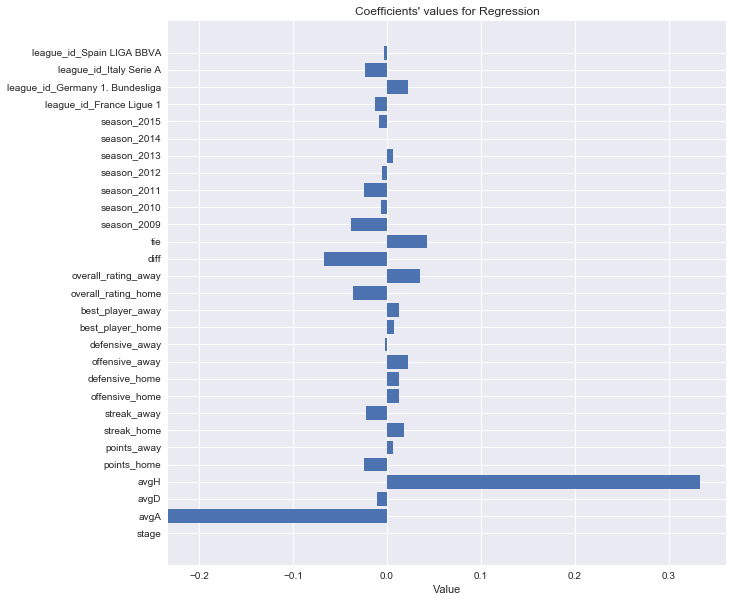

In [29]:
# Plot of coefficients values for LogisticRegressionCV or LogisticRegression
# Use LRCV or LR. Notice: uses last value of random_state above
names=list(XX.columns)
names.remove('outcome')

# Choose classifier
clf=LR
clf.fit(Xlr,ylr)

# Set plot
pos=list(np.arange(len(names))+.5)
val=clf.coef_[0]
plt.figure(figsize=(10,10))
plt.barh(pos,val, align='center')
plt.yticks(pos, names)
plt.title('Coefficients\' values for Regression')
plt.xlabel('Value')
plt.show()

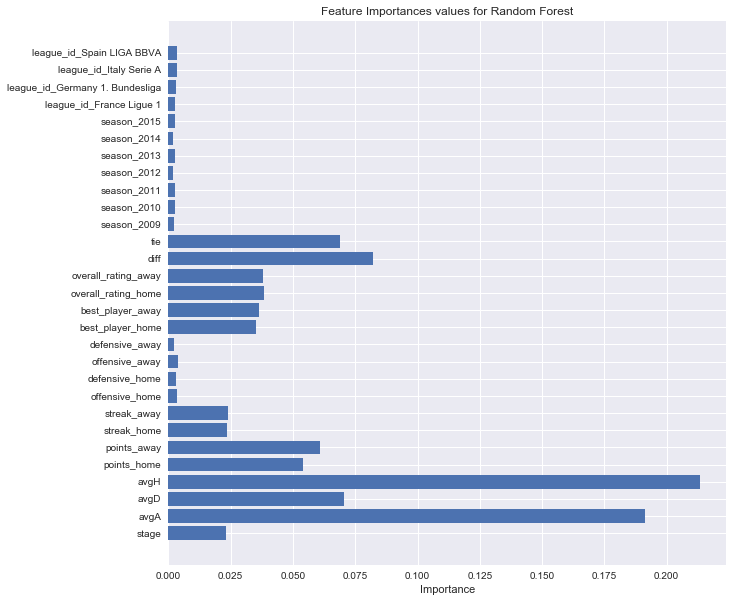

In [30]:
# Plot of feature_importances_ for RandomForest or ADABoost
# Use RF or AB. Notice: uses last value of random_state above
names=list(XX.columns)
names.remove('outcome')

# Choose classifier
clf=RF
clf.fit(Xlr,ylr)

# Set plot
pos=list(np.arange(len(names))+.5)
val=clf.feature_importances_
# val.sort()
# val=val[-len(names):]
plt.figure(figsize=(10,10))
plt.barh(pos,abs(val), align='center')
plt.yticks(pos, names)
plt.title('Feature Importances values for Random Forest')
plt.xlabel('Importance')
plt.show()

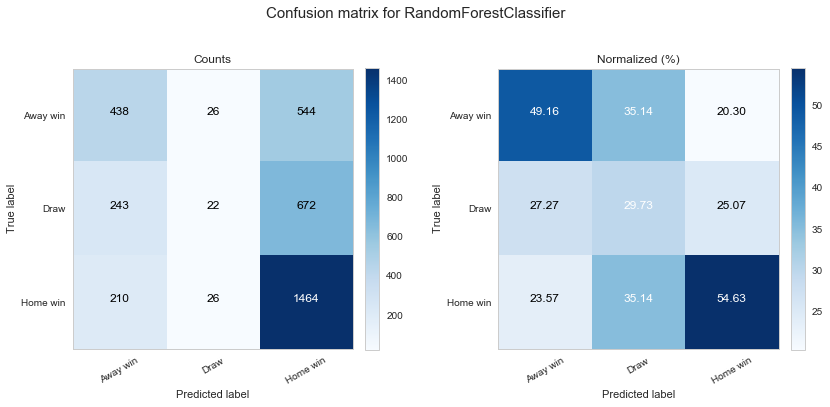

In [31]:
# Plot Confusion Matrix for chosen classifier: LRCV, LR, RF, AB

# Set classifier and train it
clf=RF
clf.fit(Xlr,ylr)

# Compute confusion matrix
cm = confusion_matrix(ytestlr, ytest)
classes = ['Away win', 'Draw', 'Home win']

# Set plot of confusion matrices, with counts and normalized
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,2,1)
plot_confusion_matrix(cm, classes=classes, normalize=False, title='Counts')

ax = fig.add_subplot(1,2,2)
plot_confusion_matrix(cm, classes=classes, normalize=True, title='Normalized (%)')
plt.tight_layout(pad=2)
plt.suptitle('Confusion matrix for {0}'.format(clf.__class__.__name__),x=.5,y=.85, fontsize=15)
# plt.savefig('confusion_matrix.png')
plt.show()
sns.set_style("whitegrid", {'axes.grid' : True})

## Calibration Plots

In [32]:
# Split Xlr and ylr, the training sets, for calibration using *ratio* of the data
ratio = .75
trn_msk, vld_msk = train_test_split(train_mask, train_size=ratio, random_state=10)
y_trn_msk, y_vld_msk = train_test_split(train_mask, train_size=ratio, random_state=10)
# trn_msk.sort(); vld_msk.sort()
X_train = XX_scaled[trn_msk,:]
X_valid = XX_scaled[vld_msk,:]
y_train = XX['outcome'][y_trn_msk]
y_valid = XX['outcome'][y_vld_msk]
# X_train, X_valid, y_train, y_valid = train_test_split(Xlr, ylr, train_size=ratio)

# Train first classifier (LRCV, LR, RF, ABRF) on whole train and validation data 
# (Xlr, ylr) and evaluate on test data (Xtestlr, ytestlr). (for comparison)
clf = RF

clf.fit(Xlr, ylr)
clf_probs = clf.predict_proba(Xtestlr)
score = log_loss(ytestlr, clf_probs, labels=np.array([-1,0,1]))

# Train second Classifier (LRCV, LR, RF, ABRF) on train data (X_train, y_train), calibrate on 
# validation data (X_valid, y_valid) and evaluate on test data (Xtestlr, ytestlr)
clf2 = RF

clf2.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf2, method='sigmoid', cv='prefit')
sig_clf.fit(X_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(Xtestlr)
sig_score = log_loss(ytestlr, sig_clf_probs, labels=np.array([-1,0,1]))

print('Log loss score of:')
print(clf.__class__.__name__, 'trained on all training samples: {0:.4f}'.format(score))
print(clf2.__class__.__name__, 'trained on {0:d}% of training samples and calibrated on other {1:d}%: {2:.4f}'\
      .format(int(100*ratio), int(100*(1-ratio)), sig_score))

clf_predict = clf.predict(Xtestlr)
sig_clf_predict = sig_clf.predict(Xtestlr)

print('\nAccuracy of {0} not calibrated: {1:.2f}%'.format(clf.__class__.__name__, 100*accuracy_score(clf_predict, ytestlr)))
print('Accuracy of {0} calibrated: {1:.2f}%'.format(clf2.__class__.__name__, 100*accuracy_score(sig_clf_predict, ytestlr)))

Log loss score of:
RandomForestClassifier trained on all training samples: 0.9833
RandomForestClassifier trained on 75% of training samples and calibrated on other 25%: 0.9869

Accuracy of RandomForestClassifier not calibrated: 52.78%
Accuracy of RandomForestClassifier calibrated: 52.78%


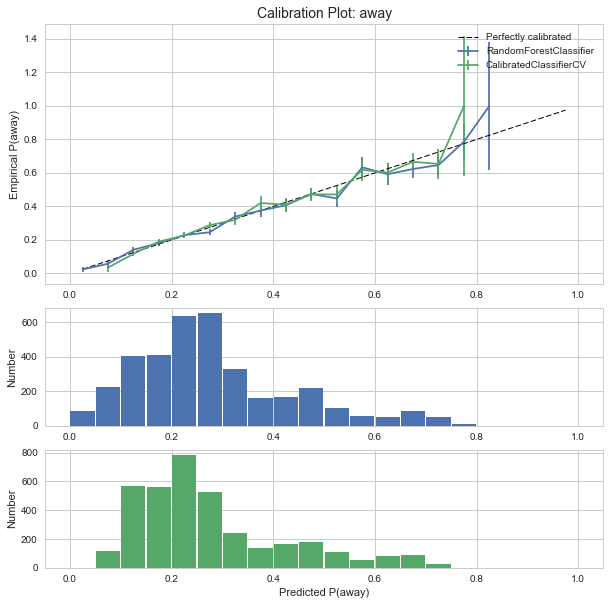

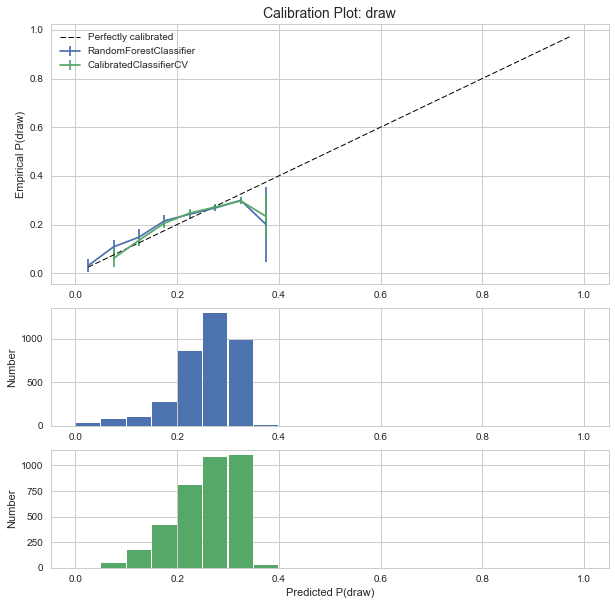

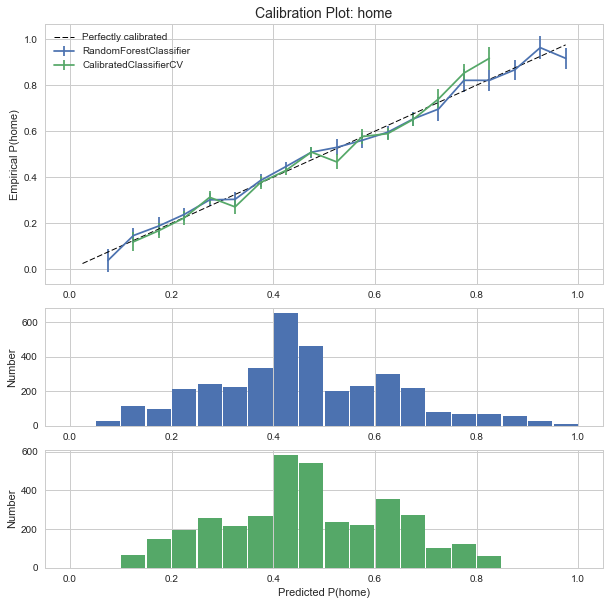

In [33]:
# Calibration plots for uncalibrated and calibrated classifiers
n=3
for col in range(n):
    calibration_plot_compare(clf, sig_clf, Xtestlr, ytestlr, col, n, save=False, file_suffix='RF')

In [34]:
# Build bookies dataframe with bookies probabilities extrapolated from average odds
bookies = 1/betdf[['avgA','avgD','avgH']]
bookies['sum'] = bookies.sum(1)
for avg in avg_lst:
    bookies[avg] = bookies[avg]/bookies['sum']
bookies['sum'] = betdf['outcome']
bookies.columns = ['probA','probD','probH','outcome']

In [35]:
tmp={'H':1, 'D':0, 'A':-1}
# Bookies accuracy score
print('Accuracy score for bookies in 5 major leagues:', \
      100*(bookies.loc[:,['probA','probD','probH']].idxmax(1).str[-1:].map(tmp) == bookies['outcome']).mean())

bookies = bookies.iloc[test_mask,:]
print('Accuracy score for bookies in test set:', \
      100*(bookies.loc[:,['probA','probD','probH']].idxmax(1).str[-1:].map(tmp) == bookies['outcome']).mean())

Accuracy score for bookies in 5 major leagues: 53.0218837895
Accuracy score for bookies in test set: 52.7297668038


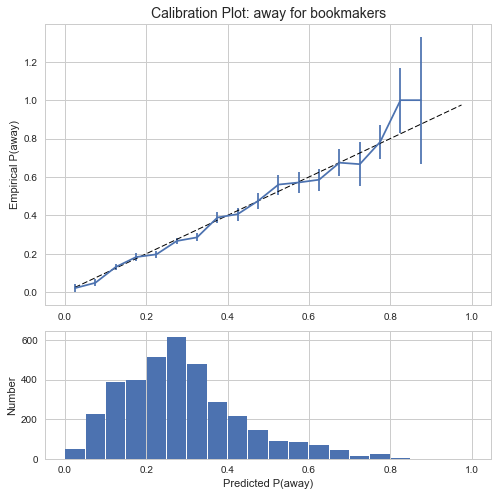

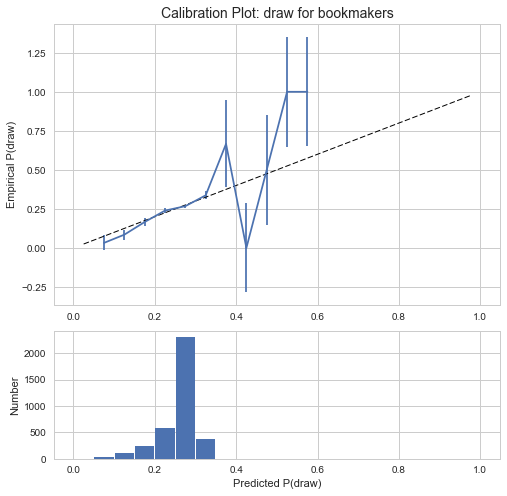

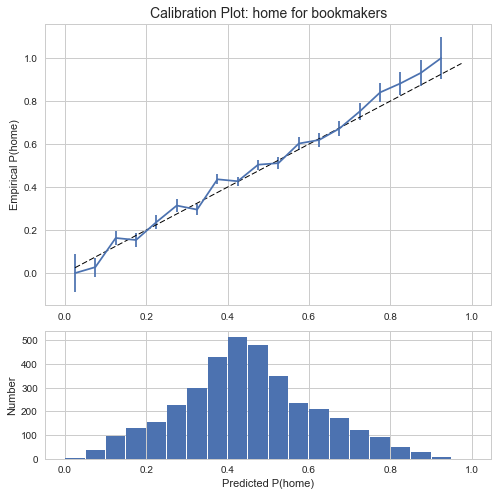

In [36]:
# Calibration plots for bookies
field = {-1:'away',0:'draw',1:'home'}
n=3
strings = ['probA','probD','probH']
for col,string in zip(range(n),strings):
    data = bookies[[string, 'outcome']]

    # Group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 21)
    cuts_bk = pd.cut(data[string], bins)
    binwidth = bins[1] - bins[0]

    # Compute empirical probability and count of examples in each bin 
    cal_bk = data.groupby(cuts_bk).outcome.apply(lambda group : get_stats(group, col, n)).unstack()
    cal_bk['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal_bk['sig'] = np.sqrt(cal_bk.pmid * (1 - cal_bk.pmid) / cal_bk['count'])

    # The calibration plot
    plt.figure(figsize=(8,8))
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal_bk.pmid, cal_bk['mean'], cal_bk['sig'])
    plt.plot(cal_bk.pmid, cal_bk.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel('Empirical P('+field[col-1]+')')
    plt.title('Calibration Plot: '+field[col-1]+' for bookmakers', fontsize=14)

    # The distribution of the probabilities
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    plt.bar(left=cal_bk.pmid, height=cal_bk['count'], width=.95 * (bins[1] - bins[0]), fc=p[0].get_color())
    plt.xlabel('Predicted P('+field[col-1]+')')
    plt.ylabel("Number")
#     plt.savefig(field[col-1]+'_cali_bookie.png')
    plt.show()

## Test models by looking at their actual ROI value

In [37]:
# Setup dfout datframe with relevant data from betdf dataframe
# Select columns with odds data from match_data 
select=[7,8,9,11]
# Add these columns if computing max/min of odds
# for i in range(85,115,3):
#     select.append(i)
# for i in range(86,115,3):
#     select.append(i)
# for i in range(87,115,3):
#     select.append(i)
# Use only test data rows, and columns with bookies average odds
dfout = betdf.iloc[test_mask,select]

In [38]:
# Select classifier, compute predicted probabilities
clf = LR
clf.fit(Xlr,ylr)

tmp = clf.predict_proba(XX_scaled[test_mask])
tmpdf = pd.DataFrame(tmp)
tmpdf.index = dfout.index  # match index with betdf index

In [41]:
# Compute commission for $10 bet assuming bookies odds are balanced, that is: payouts 
# are the same regardless of outcome when using bookies' average as odds  
bkmkrs = 1/dfout[['avgA','avgD','avgH']]
bkmkrs['sum'] = bkmkrs.sum(1)
for avg in avg_lst:
    # bkmkrs[avg] holds portion of $10 played on outcome
    bkmkrs[avg] = 10*bkmkrs[avg]/bkmkrs['sum']
    dfout['am_'+avg] = bkmkrs[avg]
dfout['bk_comm'] = round(10 - dfout['avgH']*bkmkrs['avgH'] ,2) 

# Compute bookies' average commission as percentage of bet
bk_comm = (dfout['bk_comm'].sum())/(10*dfout.shape[0])
print("With balanced bets, bookies' commission is: {0:.2f}%".format(100*bk_comm))

# Compute probabilities of model
letters = ['A','D','H']
for i,letter in enumerate(letters):
    dfout['prob'+letter] = round(tmpdf[i],4)
# Compute odds setting reduction to match 6.11% bookies commission
# reduction = .0959  # For ABRF
# reduction = .1142  # For calibrated ABRF
reduction = .1135   # For LR & RF
for i,letter in enumerate(letters):
    dfout['pred'+letter] = 1+(1/tmpdf[i]-1)*(1-reduction)

# Compute commission for $10 bet divided assuming model odds are balanced  
dfout['model_comm'] = round(10-10*dfout['probH']*dfout['predH'],2)

# Compute model's average commission as percentage of bet
model_comm = (dfout['model_comm'].sum())/(10*dfout.shape[0])
print("With balanced bets, model's commission is: {0:.2f}%".format(100*model_comm))

With balanced bets, bookies' commission is: 6.11%
With balanced bets, model's commission is: 6.11%


In [42]:
# Compare actual return of model versus actual return of bookies on all games. 
# Must set min # of games and step size. Results are stored in gd dataframe
mingames=50
maxgames = dfout.shape[0]
step = 50
gameslst=list(range(mingames,maxgames,step))
gameslst.append(maxgames-1)
gamesdict = {}
tmpdict={1:'H',0:'D',-1:'A'}
# Variables to store (progressively) total ROI
bk_total = 0
model_total = 0
# Variables to store last slice of games added
games_first = 0
for games in gameslst:
#     # Select only new games to add
    newdf = dfout[games_first:games]
#     # Update games_first
    games_first = games
#     # Check predicted strategy with actual outcomes
    newdf['outcome'] = betdf['outcome'].map(tmpdict)
    for ind,row in newdf.iterrows():
        # Amount bet is average of balanced bookies and balanced model amounts
        bk_total += 10 - 0.5*(row['am_avg'+row['outcome']]+10*row['prob'+row['outcome']])*row['avg'+row['outcome']]
        model_total += 10 - 0.5*(row['am_avg'+row['outcome']]+10*row['prob'+row['outcome']])*row['pred'+row['outcome']]
    # Store ROI results
    gamesdict[games]=[10*games, round(model_total,2), round(100*(model_total/(10*games)),2), \
                      round(bk_total,2), round(100*(bk_total/(10*games)),2)]
# Convert to dataframe for plotting
gd = pd.DataFrame.from_dict(gamesdict, orient='index')
gd.columns = ['Invested', 'Model return', 'Model ROI', 'Bookies return', 'Bookies ROI']

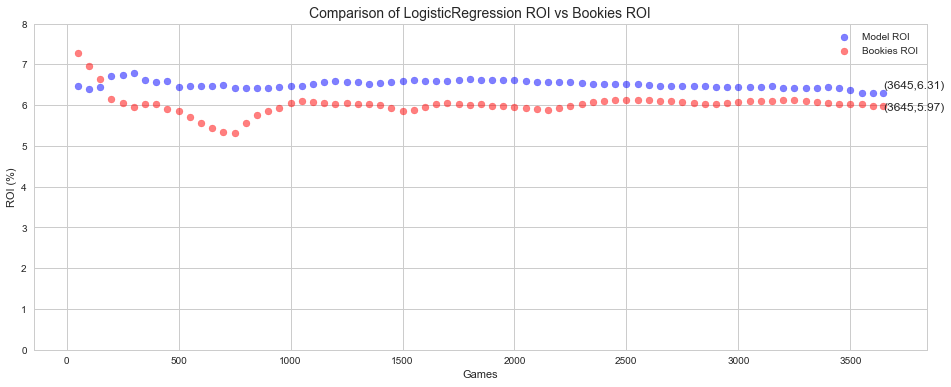

In [43]:
# Setup scatterplot
plt.figure(figsize=(16,6))
plt.scatter(list(gd.index),gd['Model ROI'],c='blue', alpha=.5)  
plt.scatter(list(gd.index),gd['Bookies ROI'],c='red', alpha=.5) 
# Annotate plot with last average ROI
for ind,row in (gd[-1:]).iterrows():
    plt.text(x=row['Invested']/10+1, y=row['Model ROI']+.1, s=str('({0:d},{1:.2f})'\
                                                        .format(int(row['Invested']/10+1),row['Model ROI'])))
    plt.text(x=row['Invested']/10+1, y=row['Bookies ROI']-.1, s=str('({0:d},{1:.2f})'\
                                                        .format(int(row['Invested']/10+1),row['Bookies ROI'])))
plt.title('Comparison of '+clf.__class__.__name__+' ROI vs Bookies ROI', fontsize=14)
plt.legend()
plt.xlabel('Games')
plt.ylabel('ROI (%)')
# Fix ylim to compare plots of different classifiers
plt.ylim(0,8)#max(gd['Model ROI'].max(),gd['Bookies ROI'].max())+.5)
# plt.savefig('LR_ROI.png')
plt.show()

# Code for testing, old versions, other attempts

### Look into predictions types and accuracy

In [ ]:
# # Using train data to find best values for modification: limit and eps
# # limit is threshold for min(predict_proba) above which we set label = 0
# # Idea: if all probabilities are close we predict match is a Draw
# ypred_proba=model.predict_proba(Xlr)
# limit = np.linspace(0.305,0.320,16)
# # eps is subbed from limit to change some home win predictions into draw predictions 
# eps = np.linspace(0.000,0.010,11)
# mod_rslt = {}
# for ep in eps:
#     mod_rslt[ep]={}
#     for val in limit:
#         ymod = ytrain.copy()
#         for i,row in enumerate(ypred_proba):
#             if min(row) >= val:
#                 ymod[i] = 0
#             elif (min(row) >= val-ep) and (max(row) == row[0]):
#                 ymod[i] = 0
#         mod_rslt[ep][val] = (ymod==ylr).mean()
# mod_rsltdf = pd.DataFrame.from_dict(mod_rslt, orient='index')
# print('Best model prediction (on training set) is now: {}'.format(mod_rsltdf.max(axis=1).max()))

In [ ]:
# Xcoord, Ycoord  = np.meshgrid(mod_rsltdf.index, mod_rsltdf.columns.values)
# zs = np.array([mod_rsltdf[y][x] for x,y in zip(np.ravel(Xcoord), np.ravel(Ycoord))])
# Zcoord = zs.reshape(Xcoord.shape)

# fig = plt.figure()
# ax = Axes3D(fig)
# surf = ax.plot_surface(Xcoord, Ycoord, Zcoord, cmap='GnBu')#, linewidth=0, antialiased=False)  #rstride=1, cstride=1,
# plt.show()

In [ ]:
# indmax = mod_rsltdf.max(axis=1).idxmax(1)
# colmax = mod_rsltdf.max(axis=0).idxmax(1)
# print('max = ',mod_rsltdf.max(0).max(), 'indmax = ',indmax, 'colmax = ', colmax)
# # print((ymod==ytestlr).mean())

In [ ]:
# ypred_proba=model.predict_proba(Xtestlr)
# ypred_proba.shape
# ymod = ytest.copy()
# w=.3
# # colmax, indmax = .320, .002
# xs = np.arange(3)-1
# ysb = [list(ytest).count(lab) for lab in xs]
# plt.bar(xs,ysb,width=w, label='before')
# for i,row in enumerate(ypred_proba):
#     if min(row) >= colmax:
#         ymod[i] = 0
#     elif (min(row) >= colmax-indmax) and (max(row) == row[0]):
#         ymod[i] = 1
# ysa = [list(ymod).count(lab) for lab in xs]
# plt.bar(xs+w,ysa,width=w, label='after')
# plt.legend()
# plt.show()

In [ ]:
# # checking what type of predictions (H-D-A) are made in test set
# labels = [1,0,-1]
# rslts = ['HOME WIN','DRAW','AWAY WIN']

# for label,res in zip(labels,rslts):
#     Xcheck = XX[XX['outcome']==label]
#     pred = ytest[ytest==label].shape[0] # ytrain[ytrain==label].shape[0]+
#     print('{0} is the result of {1:.2f}% of the games'.format(res, 100*Xcheck.shape[0]/X.shape[0]), 
#           'and is predicted {0:.2f}% of the times.'.format(100*pred/Xtestlr.shape[0]))
#     # checking modified vector
#     predmod = ymod[ymod==label].shape[0] # ytrain[ytrain==label].shape[0]+
#     print('{0} is the result of {1:.2f}% of the games'.format(res, 100*Xcheck.shape[0]/X.shape[0]), 
#           'and after modifying is predicted {0:.2f}% of the times.'.format(100*predmod/Xtestlr.shape[0]))
   
# # checking how many predictions are correct by predicted outcome in test set
# for label,res in zip(labels,rslts):
#     pred = ((ytestlr==ytest) & (ytest == label)).sum() / (ytest == label).sum()
#     print('\nThere were {} {} predictions.'.format((ytest == label).sum(), res))
#     print('{0} predictions are correct {1:.2f}% of the times.'.format(res, 100*pred)) 
#     # checking as well with modified values
#     predmod = ((ytestlr==ymod) & (ymod == label)).sum() / (ymod == label).sum()
#     print('\nAfter modifying there were {} {} predictions.'.format((ymod == label).sum(), res))
#     print('{0} predictions are correct {1:.2f}% of the times.'.format(res, 100*predmod)) 
    
# print('\nBefore modifying model score was {}'.format((ytestlr == ytest).mean()))
# print('After modifying model score was {}'.format((ytestlr == ymod).mean()))

## Features building
The space below contains code for features under testing. Once the code works it is moved higher (as function) and the call to it happens in **Building X Dataframe for Prediction** section.

In [ ]:
# # Prepare Xtry dataframe for two rounds predictions: first we predict whether Home Win or not,
# # then on matches not predicted as home win we run regular multinomial classifier to predict
# # Home win, Draw or Away win.
# Xtry = X.loc[:,(X.columns != 'season') & (X.columns != 'league_id')]
# Xtry['outcome2'] = (Xtry['outcome'] == 1)*1
# Xtry_scaled = preprocessing.scale(Xtry.loc[:, (Xtry.columns != 'outcome2') & (Xtry.columns != 'outcome')])

#### Training on full training set

In [ ]:
# rs = np.arange(10)+1
# try_res = {}
# res2 = {}
# for r in rs:
#     Xtry_train, Xtry_test, ytry_train, ytry_test = train_test_split(Xtry_scaled, Xtry['outcome2'], random_state=r)
#     X2_train, X2_test, y2_train, y2_test = train_test_split(Xtry_scaled, Xtry['outcome'], random_state=r)
# ###### Train classifier on [0,1] outcomes from Xtry ######
#     clftry = LogisticRegression(C=0.01, solver='sag')
# #     clftry = RandomForestClassifier(n_estimators=50, max_depth=6, max_features='sqrt')
#     clftry.fit(Xtry_train,ytry_train)

# ###### Train classifier on [-1,0,1] outcomes from X2 ######
#     clf2 = LogisticRegression(C=0.01, solver='sag', class_weight={-1:1.5,0:1.25,1:1})    
# #     clf2 = RandomForestClassifier(n_estimators=50, max_depth=6, max_features='sqrt', class_weight={-1:1,0:.8,1:1.25})
#     clf2.fit(X2_train,y2_train)
    
# ###### Predict labels on train and test set with clftry ######
#     try_pred_train = clftry.predict(Xtry_train)
#     try_pred_test = clftry.predict(Xtry_test)
#     # Store scores
#     try_res[r] = {'Train score': 100*accuracy_score(try_pred_train,ytry_train), \
#                   'Test score': 100*accuracy_score(try_pred_test,ytry_test)}

# ###### Predict labels on train and test set with clf2 
#     pred2_train = clf2.predict(X2_train)
#     pred2_test = clf2.predict(X2_test)
#     # Store scores 
#     res2[r] = {'Train score': 100*accuracy_score(pred2_train,y2_train), 'Test score': 100*accuracy_score(pred2_test,y2_test)}

#### Training on Not Home Win predictions

In [ ]:
# rs = np.arange(10)+1
# try_res = {}
# res2 = {}
# for r in rs:
#     Xtry_train, Xtry_test, ytry_train, ytry_test = train_test_split(Xtry_scaled, Xtry['outcome2'], random_state=r)
#     X2_train, X2_test, y2_train, y2_test = train_test_split(Xtry_scaled, Xtry['outcome'], random_state=r)

# ###### Train classifier on [0,1] outcomes from Xtry ######
# #     clftry = LogisticRegression(C=0.01, solver='sag')
#     clftry = RandomForestClassifier(n_estimators=30, max_depth=6, max_features='sqrt')
#     clftry.fit(Xtry_train,ytry_train)
    
# ###### Predict labels on train and test set with clftry ######
#     try_pred_train = clftry.predict(Xtry_train)
#     try_pred_test = clftry.predict(Xtry_test)
#     try_res[r] = {'Train score': 100*accuracy_score(try_pred_train,ytry_train), \
#                   'Test score': 100*accuracy_score(try_pred_test,ytry_test)}

# ###################################################################
# #### Train second classifier on Not Home Win training samples
# #     clf2 = LogisticRegression(C=0.01, solver='sag', class_weight={-1:1,0:1.1,1:1.1})    
#     clf2 = RandomForestClassifier(n_estimators=30, max_depth=6, max_features='sqrt', class_weight={-1:1,0:.8,1:.85})

#     d_f = pd.DataFrame(try_pred_train, columns=['pred'])
#     indexes=d_f[d_f.pred==0].index.values
#     ytrue_train = (y2_train.reset_index(drop=True))[indexes]
#     clf2.fit(Xtry_train[try_pred_train==0],ytrue_train)
# ###################################################################

# ###### Predict labels on train and test set with clf2 
#     pred2_train = clf2.predict(Xtry_train[try_pred_train==0])
#     pred2_test = clf2.predict(X2_test)
#     res2[r] = {'Train score': 100*accuracy_score(pred2_train,ytrue_train), 'Test score': 100*accuracy_score(pred2_test,y2_test)}

#### Common code to test results

In [ ]:
# try_scores = pd.DataFrame(try_res)
# print(try_scores.median(axis=1))
# try_scores

In [ ]:
# # Check type of predictions on last run
# print('{0:3d} Home Win predictions: {1:.2f}% correct.'.format(np.unique(try_pred_test, return_counts=True)[1][1],\
#                                     100*(try_pred_test[try_pred_test == 1] == ytry_test[try_pred_test == 1]).mean()))
# print('{0:3d} Other predictions: {1:.2f}% correct.'.format(np.unique(try_pred_test, return_counts=True)[1][0], \
#                                     100*(try_pred_test[try_pred_test == 0] == ytry_test[try_pred_test == 0]).mean()))

In [ ]:
# # Just checking overfit here real numbers below
# scores2 = pd.DataFrame(res2)
# print(scores2.median(axis=1))
# # Check type of predictions on last run
# print('\nIn the last run:')
# print('There were {0:3d} Home Win predictions. {1:.2f}% were correct.'.format(np.unique(pred2_test, return_counts=True)[1][2], \
#                                              100*(pred2_test[pred2_test == 1] == y2_test[pred2_test == 1]).mean()))
# print('There were {0:3d} Draw predictions. {1:.2f}% were correct.'.format(np.unique(pred2_test, return_counts=True)[1][1], \
#                                             100*(pred2_test[pred2_test == 0] == y2_test[pred2_test == 0]).mean()))
# print('There were {0:3d} Away Win predictions. {1:.2f}% were correct.'.format(np.unique(pred2_test, return_counts=True)[1][0], \
#                                             100*(pred2_test[pred2_test == -1] == y2_test[pred2_test == -1]).mean()))
# scores2

In [ ]:
# ###### Actual number of correct predictions! ######
# clf_test = clftry.predict(Xtry_test)
# lab1 = (clf_test == 1).sum()
# lab2 = clf_test.shape[0] - lab1
# secondround = clf2.predict(Xtry_test[clf_test==0])
# cf = pd.DataFrame(clf_test, columns=['pred'])
# indexes=cf[cf.pred==0].index.values
# yy = y2_test.reset_index(drop=True)
# ysecond = yy[indexes]

# acc1 = accuracy_score(clf_test[clf_test == 1],ytry_test[clf_test == 1])
# print('Accuracy on Home Win/Not Home Win: {0:.2f}'.format(100*acc1))
# acc2 = accuracy_score(secondround,ysecond)
# print('Accuracy on Home/Draw/Away for Not Home Win predictions: {0:.2f}'.format(100*acc2))
# accscore = (lab1*acc1 + lab2*acc2)/clf_test.shape[0]
# print('Method accuracy score: {0:.2f}%'.format(100*accscore))

In [ ]:
# # Check type of predictions on last run
# print('There were {0:3d} Home Win predictions. {1:.2f}% were correct.'.format(np.unique(secondround, return_counts=True)[1][2], \
#                                              100*(secondround[secondround == 1] == ysecond[secondround == 1]).mean()))
# print('There were {0:3d} Draw predictions. {1:.2f}% were correct.'.format(np.unique(secondround, return_counts=True)[1][1], \
#                                             100*(secondround[secondround == 0] == ysecond[secondround == 0]).mean()))
# print('There were {0:3d} Away Win predictions. {1:.2f}% were correct.'.format(np.unique(secondround, return_counts=True)[1][0], \
#                                             100*(secondround[secondround == -1] == ysecond[secondround == -1]).mean()))

In [ ]:
# n=2
# for col in range(n):
#     calibration_plot(clftry, Xtry_train, ytry_train, col, n)

In [ ]:
# probs = clftry.predict_proba(Xtry_train)
# # print('minimum probs are: ',probs[:,0].min(),probs[:,1].min())
# # print('to avoid negative must be > than',1/16)
# probs = (9/8)*probs-(1/16)
# # print('minimum probs are: ',probs[:,0].min(),probs[:,1].min())
# caldf = pd.DataFrame(probs)
# caldf['outcome'] = ytry_train.reset_index(drop=True)

In [ ]:
# n= 2
# for col in range(n):
#     data = caldf[[col, 'outcome']]

#     # Group outcomes into bins of similar probability
#     bins = np.linspace(0, 1, 21)
#     cuts_bk = pd.cut(data[col], bins)
#     binwidth = bins[1] - bins[0]

#     # Compute empirical probability and count of examples in each bin 
#     cal_bk = data.groupby(cuts_bk).outcome.apply(lambda group : get_stats(group, col, n)).unstack()
#     cal_bk['pmid'] = (bins[:-1] + bins[1:]) / 2
#     cal_bk['sig'] = np.sqrt(cal_bk.pmid * (1 - cal_bk.pmid) / cal_bk['count'])

#     # The calibration plot
#     plt.figure(figsize=(12,8))
#     ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
#     p = plt.errorbar(cal_bk.pmid, cal_bk['mean'], cal_bk['sig'])
#     plt.plot(cal_bk.pmid, cal_bk.pmid, linestyle='--', lw=1, color='k')
#     plt.ylabel('Empirical P({0:d})'.format(col))

#     # The distribution of the probabilities
#     ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
#     plt.bar(left=cal_bk.pmid - binwidth / 2, height=cal_bk['count'], width=.95 * (bins[1] - bins[0]), fc=p[0].get_color())
#     plt.xlabel('Predicted P({0:d})'.format(col))
#     plt.ylabel("Number")
#     plt.show()

In [ ]:
# np.unique(clf2.predict(X2_train), return_counts=True)

In [ ]:
# n=3
# for col in range(n):
#     calibration_plot(clf2, X2_train, y2_train, col, n)

In [ ]:
# probs = clf2.predict_proba(X2_train)
# # probs = (9/8)*probs-(1/16)
# caldf = pd.DataFrame(probs)
# caldf.iloc[:,0] = caldf.iloc[:,0]+(caldf.iloc[:,0]>.6)*.10+(caldf.iloc[:,0]>.7)*.10+(caldf.iloc[:,0]>.8)*.10
# caldf.iloc[:,1] = caldf.iloc[:,1]+(caldf.iloc[:,0]>.2)*.06
# caldf.iloc[:,2] = caldf.iloc[:,2]-(caldf.iloc[:,2]<.75)*.08
# caldf.loc[caldf.iloc[:,2] <1/40,2] = 1/40
# caldf['sum'] = caldf.sum(1)
# for i in range(3):
#     caldf.iloc[:,i] = caldf.iloc[:,i]/caldf['sum']
# del caldf['sum']
# caldf['outcome'] = y2_train.reset_index(drop=True)
# # caldf['prediction'] = clf2.predict(X2_train)
# # caldf['argmax_probs'] = probs.argmax(1)-1
# # caldf['argmax_mod_probs'] = caldf.iloc[:,:3].idxmax(1)-1
# # print((caldf['argmax_mod_probs'] == caldf['argmax_probs']).mean())
# caldf.head(3)

In [ ]:
# n=3
# for col in range(n):
#     data = caldf[[col, 'outcome']]

#     # Group outcomes into bins of similar probability
#     bins = np.linspace(0, 1, 21)
#     cuts_bk = pd.cut(data[col], bins)
#     binwidth = bins[1] - bins[0]

#     # Compute empirical probability and count of examples in each bin 
#     cal_bk = data.groupby(cuts_bk).outcome.apply(lambda group : get_stats(group, col, n)).unstack()
#     cal_bk['pmid'] = (bins[:-1] + bins[1:]) / 2
#     cal_bk['sig'] = np.sqrt(cal_bk.pmid * (1 - cal_bk.pmid) / cal_bk['count'])
    
#     # Adjust col value
#     if n==3:
#         col=col-1
        
#     # The calibration plot
#     plt.figure(figsize=(12,8))
#     ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
#     p = plt.errorbar(cal_bk.pmid, cal_bk['mean'], cal_bk['sig'])
#     plt.plot(cal_bk.pmid, cal_bk.pmid, linestyle='--', lw=1, color='k')
#     plt.ylabel('Empirical P({0:d})'.format(col))

#     # The distribution of the probabilities
#     ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)  ### left=cal_bk.pmid - binwidth / 2
#     plt.bar(left=cal_bk.pmid, height=cal_bk['count'], width=.95 * (bins[1] - bins[0]), fc=p[0].get_color())
#     plt.xlabel('Predicted P({0:d})'.format(col))
#     plt.ylabel("Number")
#     plt.show()

### Looking at actual return of old and new predictions

In [ ]:
# # Compute odds setting reduction at 10%
# probs = clf2.predict_proba(X2_train)
# reduction = .06
# for i in range(3):
#     caldf['old'+str(i)] = 1+(1/abs(probs[:,i])-1)*(1-reduction)
#     caldf['old'+str(i)] = round(caldf['old'+str(i)],2)
#     caldf['new'+str(i)] = round(1+(1/abs(caldf[i])-1)*(1-reduction),2)
# # Difference New-Old in payout, negative when New is better (as bookie)
# for ind,row in caldf.iterrows():
#     caldf.loc[ind,'diff']=10*(row['new'+str(int(row['outcome'])+1)] - row['old'+str(int(row['outcome'])+1)])
# caldf.head(3)

In [ ]:
# %%time
# # Compare actual return of model versus actual return of bookies on 10% of games. 
# # Must set min # of games and step size. Results are stored in gd dataframe
# mingames=100
# maxgames = int(caldf.shape[0]/1)  
# step = 100
# gameslst=range(mingames,maxgames,step)
# gamesdict = {}
# tmpdict={1:'2',0:'1',-1:'0'}
# old_total = 0
# new_total = 0
# for games in gameslst:
#     newdf = caldf[games-step:games]  
#     newdf['outcome'] = newdf['outcome'].map(tmpdict)
#     for ind,row in newdf.iterrows():
#         old_total += 30 - 10*row['old'+row['outcome']]
#         new_total += 30 - 10*row['new'+row['outcome']]
#     gamesdict[games]=[10*games, round(new_total,2), round(100*(new_total/(10*games)),2), \
#                       round(old_total,2), round(100*(old_total/(10*games)),2)]
# gd = pd.DataFrame.from_dict(gamesdict, orient='index')
# gd.columns = ['Invested', 'New return', 'New ROI', 'Old return', 'Old ROI']

In [ ]:
# plt.figure(figsize=(16,6))
# plt.scatter(list(gd.index),gd['New ROI'],c='blue', alpha=.5)  
# plt.scatter(list(gd.index),gd['Old ROI'],c='red', alpha=.5) 
# for ind,row in (gd[-1:]).iterrows():
#     plt.text(x=row['Invested']/10, y=row['New ROI'], s=str('({0:d},{1:.1f})'.format(int(row['Invested']/10),row['New ROI'])))
#     plt.text(x=row['Invested']/10, y=row['Old ROI'], s=str('({0:d},{1:.1f})'.format(int(row['Invested']/10),row['Old ROI'])))
# plt.title('Comparison of New vs Old ROI')
# # plt.ylim((-80,-40))
# plt.legend()
# plt.show()

### PCA dimensionality reduction

In [ ]:
# Xcopy = X.loc[:,X.columns != 'outcome']
# del Xcopy['league_id']

# # print(Xcopy.columns.values)
# #### highest correlated columns ####
# # del Xcopy['diff']
# # del Xcopy['penalties_away']
# # del Xcopy['penalties_home']
# # del Xcopy['ball_control_home']
# # del Xcopy['ball_control_away']
# # del Xcopy['potential_home']
# # del Xcopy['potential_away']
# # del Xcopy['gk_positioning_away']
# # del Xcopy['gk_positioning_home']
# # del Xcopy['interceptions_home']
# # del Xcopy['interceptions_away']
# # del Xcopy['standing_tackle_home']
# # del Xcopy['standing_tackle_away']



# # PREPROCESSING: Square all features
# # Xcopy = X.iloc[:,2:20]
# # del Xcopy['outcome']
# # matrix = Xcopy.values
# # poly = preprocessing.PolynomialFeatures(2)
# # matrix = poly.fit_transform(matrix)

# matrix = Xcopy.values
# pca = PCA()
# pca.fit(matrix)

# n_comps = [2,3,4,5,6,7,8,9,10]
# resultsPCA = {}
# for n_comp in n_comps:
#     print('Explained variance with {0:d} components: {1:0.2f}%'.format(n_comp,100*pca.explained_variance_ratio_[:n_comp].sum()))
#     for i in range(n_comp):
#         Xcopy['x_'+str(i)] = pca.fit_transform(matrix)[:,i]
#     XLR = Xcopy.iloc[:,-n_comp:]
# #     print('Max correlation before PCA:',((Xcopy.iloc[:,:-n_comp].corr()-np.eye(Xcopy.iloc[:,:-n_comp].corr().shape[0])).max(1)).max())
# #     print('Max correlation after PCA:',((XLR.corr()-np.eye(XLR.corr().shape[0])).max(1)).max())
#     # print((Xcopy.iloc[:,:-n_comp].corr()-np.eye(Xcopy.iloc[:,:-n_comp].corr().shape[0])).max(1)[:])

#     XLR_scaled = preprocessing.scale(XLR.loc[:, XLR.columns != 'outcome'])
#     rs = np.arange(3)+1
#     resultsPCA[n_comp] = {}
#     for r in rs:
#         # Break data into training and test: use XLR or XLR_scaled 
#         PCAtrainX, PCAtestX, PCAtrainY, PCAtestY = train_test_split(XLR_scaled, X['outcome'], random_state=r)
#         Cs =  [ 0.0033, 0.01, 0.033, 0.1]#, 0.33, 1, 3.3, 10, 33]

#         PCAmodel = LogisticRegressionCV(Cs=Cs, cv=5, scoring='accuracy', solver='sag', n_jobs=-1, random_state=r, \
#                                         multi_class='multinomial')
# #         PCAmodel = RandomForestClassifier(n_estimators=50, max_depth=5, max_features='sqrt')
#     #     PCAmodel = GaussianNB()

#         PCAmodel.fit(PCAtrainX,PCAtrainY)
#         # Compute accuracy on train and test sets
#         ytrain = PCAmodel.predict(PCAtrainX)
#         ytest = PCAmodel.predict(PCAtestX)

#         resultsPCA[n_comp][r] = {'Train score': 100*accuracy_score(ytrain,PCAtrainY), \
#                                  'Test score': 100*accuracy_score(ytest,PCAtestY)  , 'Best C': PCAmodel.C_[0]}

# scoresPCA = pd.DataFrame(resultsPCA)

In [ ]:
# for n_comp in n_comps:
#     for n in range(3):
#         print(n_comp,scoresPCA[n_comp].values[n])

### Replacing player id with actual name

In [ ]:
# # creating dictionary with player_api_id and player_name
# player_dict = pd.Series(player_data['player_name'].values,index=player_data['player_api_id']).to_dict()

# for i in range(11):
#     # replacing player number id with player name
#     home='home_player_'+str(i+1)
#     away='away_player_'+str(i+1)
#     match_data[home] = (match_data[home]).map(player_dict)  
#     match_data[away] = (match_data[away]).map(player_dict) 

In [ ]:
# # Check type of predictions
# print('In the last run:')
# print('There were {0:3d} Home Win predictions. {1:.2f}% were correct.'.format(np.unique(ytest, return_counts=True)[1][2], \
#                                                                    100*(ytest[ytest == 1] == ytestlr[ytest == 1]).mean()))
# print('There were {0:3d} Draw predictions. {1:.2f}% were correct.'.format(np.unique(ytest, return_counts=True)[1][1], \
#                                                             100*(ytest[ytest == 0] == ytestlr[ytest == 0]).mean()))
# print('There were {0:3d} Away Win predictions. {1:.2f}% were correct.'.format(np.unique(ytest, return_counts=True)[1][0], \
#                                                               100*(ytest[ytest == -1] == ytestlr[ytest == -1]).mean()))
# # Identify highly correlated variables
# (XX.corr()-np.eye(XX.corr().shape[0])).max(0)